In [1]:
from pprint import pprint
import seaborn as sns
import numpy as np
from sqlalchemy import PickleType
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import pickle
import logging
import yaml
from copy import deepcopy
import torch

from utils.data_storage.dataframe2sql import read_pkl_sql
from utils.config.loaders import get_sql_types, get_default_integrator_config
from zunis.integration import Integrator
sns.set_theme()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
from itertools import product

In [2]:
get_default_integrator_config()

Configuration({'flow': 'pwquad', 'flow_options': NestedMapping({'cell_params': NestedMapping({'d_hidden': 256, 'n_bins': 10, 'n_hidden': 8}), 'masking': 'iflow', 'masking_options': NestedMapping({'repetitions': 2})}), 'loss': 'variance', 'n_points_survey': 10000, 'n_iter': 10, 'trainer_options': NestedMapping({'minibatch_size': 1.0, 'max_reloads': 0, 'n_epochs': 50, 'optim': NestedMapping({'optim_cls': 'Adam', 'optim_config': NestedMapping({'betas': (0.9, 0.999), 'eps': 1e-08, 'lr': 0.001})}), 'checkpoint': True, 'checkpoint_on_cuda': True, 'checkpoint_path': None})})

In [3]:
from utils.benchmark.vegas_benchmarks import VegasRandomHPBenchmarker
from utils.config.loaders import get_sql_types
from utils.config.configuration import Configuration

from utils.integrands.pretty import CircleLineIntegrand, SineIntegrand, SineLineIntegrand
from utils.integrands.gaussian import DiagonalGaussianIntegrand, CamelIntegrand
from utils.integrands.volume import HyperrectangleVolumeIntegrand, HypersphereVolumeIntegrand

In [4]:
dtypes = get_sql_types()

In [5]:
def get_loss_history(result):
    return sum(result.loc[0,"value_history"]["training record"].apply(lambda x: x["metrics"]["loss"]),[])

# Camel integrand

In [6]:
d=4
s = 0.3
norm = 1

In [7]:
def camel_pretty_plot(config):
    
    benchmarker = VegasRandomHPBenchmarker(n=1)
    config = benchmarker.set_benchmark_grid_config(config=config, cuda=0)
    return benchmarker.run(integrand=CamelIntegrand, **config)
    


In [8]:
base_config = Configuration({
    "dimensions": d,
    "base_integrand_params": {
        "s": 0.3,
        "norm": 1
    },
    "base_integrator_config": {
        "checkpoint_on_cuda": False,
        "n_bins": 50,
        "lr": 1.e-3,
        "n_hidden": 2,
        "d_hidden": 32,
        "n_epochs": 50
        
    },
    "debug":False,
    "experiment_name": "camel_pretty_plot",
    "keep_history": True
}, check=False)



Logging into ./camel_pretty_plot:aa04866.log
      value    target  variance_ratio  percent_difference  match
0  0.001967  0.001959       92.002118            0.406633   True


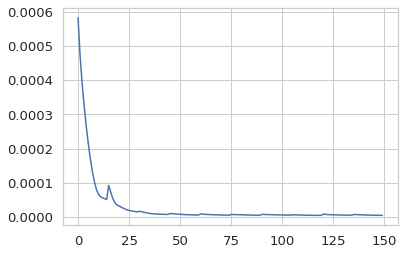

In [15]:
config = deepcopy(base_config)
config["d_hidden"] = 150
config["n_bins"] = 25
config["n_hidden"] = 4
config["n_epochs"] = 15
config['lr'] = 1.e-3
result, integrator = camel_pretty_plot(config)
print(result[["value", "target", "variance_ratio" , "percent_difference", "match"]])

fig, ax = plt.subplots()
ax.plot(get_loss_history(result))
#ax.set(ylim=[1.e-4,1.e-2])
plt.show()


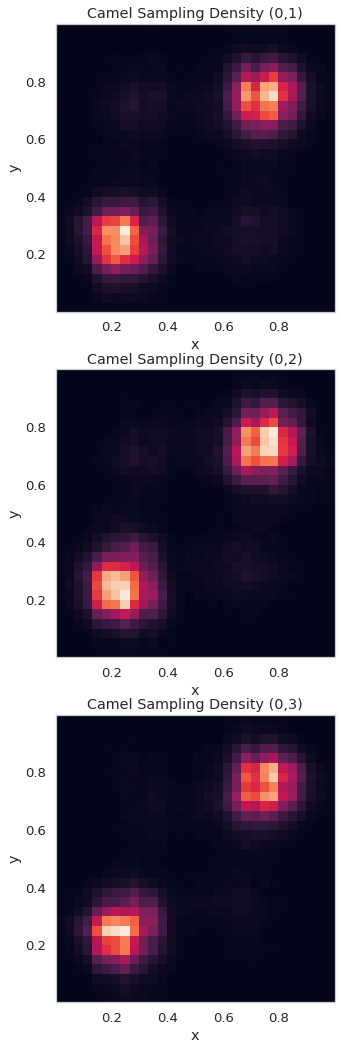

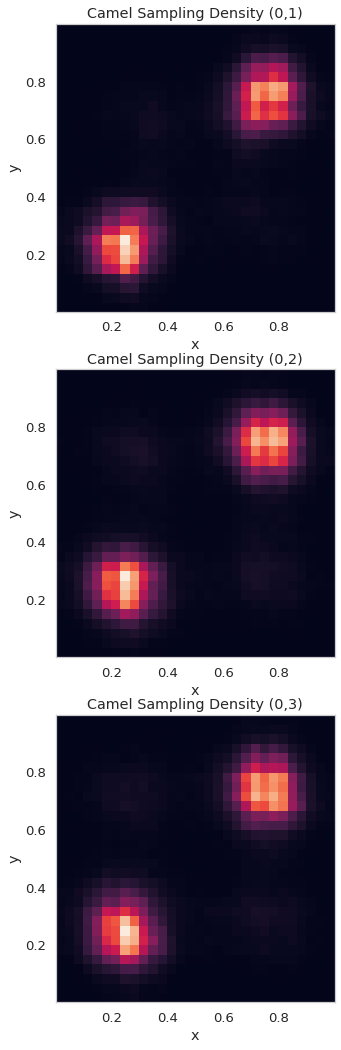

In [16]:
x, _, _ = integrator.sample_refine()
x = x.cpu().numpy()
fig, ax = plt.subplots(d-1,1)
fig.set_size_inches(5,6*(d-1))
for i in range(d-1):
    ax[i].hist2d(x[:100000,0],x[:100000,i+1], bins=30)
    ax[i].set(xlabel="x", ylabel="y", title=f"Camel Sampling Density (0,{i+1})")
plt.show()
x, _, _ = integrator.sample_refine()
x = x.cpu().numpy()
fig, ax = plt.subplots(d-1,1)
fig.set_size_inches(5,6*(d-1))
for i in range(d-1):
    ax[i].hist2d(x[:100000,d-1],x[:100000,i], bins=30)
    ax[i].set(xlabel="x", ylabel="y", title=f"Camel Sampling Density (0,{i+1})")
plt.show()

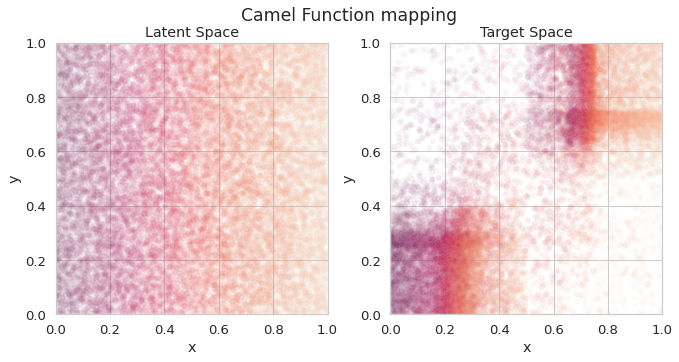

In [135]:
x, _, _ = integrator.sample_survey(n_points=20000)
x = x.cpu()
fig, axs = plt.subplots(1,2)
sns.scatterplot(x=x[:,0], y=x[:,1], hue=x[:,0], legend=False, palette="rocket", hue_norm=(-.5,1.2),alpha=0.05, ax=axs[0])

x = x.to("cuda")
x = torch.cat((x, torch.ones(len(x), device="cuda").unsqueeze(-1)), dim=-1)
y = integrator.model_trainer.flow(x)[:,:2].detach().cpu()
x = x.cpu()

sns.scatterplot(x=y[:,0], y=y[:,1], hue=x[:,0],legend=False, palette="rocket", hue_norm=(-.5,1.2),alpha=0.05, ax=axs[1])
axs[0].set(aspect=1, xlabel="x", ylabel="y", title="Latent Space", xlim=[0,1], ylim=[0,1])
axs[1].set(aspect=1, xlabel="x", ylabel="y", title="Target Space", xlim=[0,1], ylim=[0,1])
fig.set(size_inches=(11,5))
fig.suptitle("Camel Function mapping")
plt.show()

In [328]:
colors = ["#751a35", "#b34233", "#d28f33", "#d4b95e", "#4ea2a2"]
colors_husl = [(0, 78, 60),
               (16, 73, 60),
               (46, 88, 60),
               (69, 75, 60),
               (192, 75, 61)]
divpal = [
    sns.diverging_palette(c[0], c[0]+30, s=c[1], l=c[2], as_cmap=True, center="dark", sep=1) for c in colors_husl
]

named_palettes = ["rocket_r", "crest", "viridis", "flare", "magma"]
alternating = ["flare", "flare_r", "flare", "flare_r", 'flare']

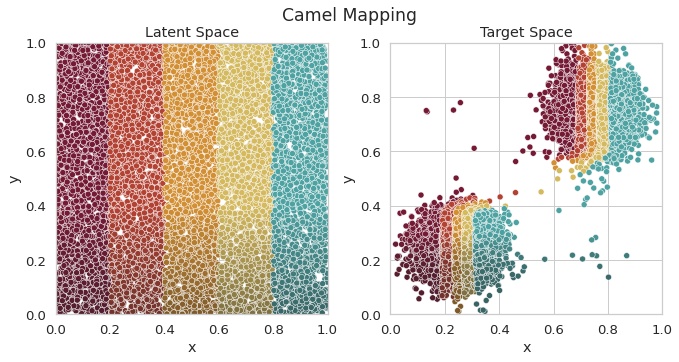

In [329]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,5)
colors = ["#751a35", "#b34233", "#d28f33", "#d4b95e", "#4ea2a2"]
for i in range(5):
    low = i*0.2
    high = low+0.2
    
    x, _, _ = integrator.sample_survey()
    x = x.cpu()
    x=x[((low<x[:, 0]) &  (x[:,0] < high))]

    sns.scatterplot(x=x[:,0], y=x[:,1], hue=x[:,1], legend=False, palette=sns.dark_palette(colors[i], as_cmap=True), hue_norm=(-.4,.4), ax=axs[0])



    x = x.to("cuda")
    x = torch.cat((x, torch.ones(len(x), device="cuda").unsqueeze(-1)), dim=-1)
    y = integrator.model_trainer.flow(x)[:,:2].detach().cpu()
    x = x.cpu()

    sns.scatterplot(x=y[:,0], y=y[:,1], hue=x[:,1], legend=False, palette=sns.dark_palette(colors[i], as_cmap=True), hue_norm=(-.4,.4),ax=axs[1])

axs[0].set(aspect=1, xlabel="x", ylabel="y", title="Latent Space", xlim=[0,1], ylim=[0,1])
axs[1].set(aspect=1, xlabel="x", ylabel="y", title="Target Space", xlim=[0,1], ylim=[0,1])
fig.set(size_inches=(11,5))
fig.suptitle("Camel Mapping")
plt.show()

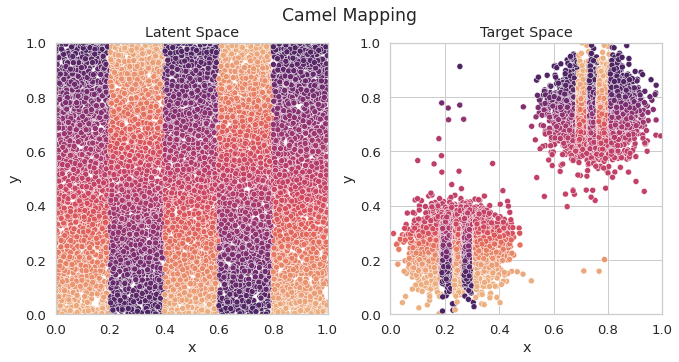

In [330]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,5)
colors = ["#751a35", "#b34233", "#d28f33", "#d4b95e", "#4ea2a2"]
for i in range(5):
    low = i*0.2
    high = low+0.2
    
    x, _, _ = integrator.sample_survey()
    x = x.cpu()
    x=x[((low<x[:, 0]) &  (x[:,0] < high))]

    sns.scatterplot(x=x[:,0], y=x[:,1], hue=x[:,1], legend=False, palette=alternating[i], ax=axs[0])



    x = x.to("cuda")
    x = torch.cat((x, torch.ones(len(x), device="cuda").unsqueeze(-1)), dim=-1)
    y = integrator.model_trainer.flow(x)[:,:2].detach().cpu()
    x = x.cpu()

    sns.scatterplot(x=y[:,0], y=y[:,1], hue=x[:,1], legend=False, palette=alternating[i],ax=axs[1])

axs[0].set(aspect=1, xlabel="x", ylabel="y", title="Latent Space", xlim=[0,1], ylim=[0,1])
axs[1].set(aspect=1, xlabel="x", ylabel="y", title="Target Space", xlim=[0,1], ylim=[0,1])
fig.set(size_inches=(11,5))
fig.suptitle("Camel Mapping")
plt.show()

# CircleLine integrand

In [331]:
d = 2
s = 0.3
norm = 1

In [332]:
def cl_pretty_plot(config):
    
    benchmarker = VegasRandomHPBenchmarker(n=1)
    config = benchmarker.set_benchmark_grid_config(config=config, cuda=0)
    return benchmarker.run(integrand=CircleLineIntegrand, **config)
    


In [333]:
base_config = Configuration({
    "dimensions": d,
    "base_integrand_params": {
        "r":0.3,
        "sig":0.05
    },
    "base_integrator_config": {
        "checkpoint_on_cuda": False,
        "n_bins": 30,
        "checkpoint_path": "pretty_caml.chkpt",
        "n_epochs": 20,
        "lr": 1.e-3
    },
    "debug":False,
    "experiment_name": "camel_pretty_plot",
    "keep_history": True
}, check=False)



Logging into ./camel_pretty_plot:ba7f99f.log
0    25.138888
Name: variance_ratio, dtype: float64


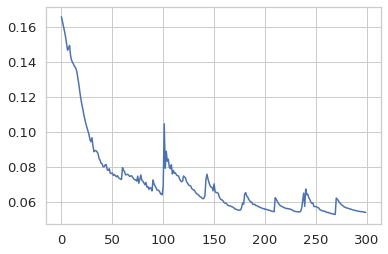

In [334]:
config = deepcopy(base_config)
config["n_epochs"] = 30
config["n_bins"] = 100
config["lr"] = 1e-3
result, integrator = cl_pretty_plot(config)
print(result["variance_ratio"])

fig, ax = plt.subplots()
ax.plot(get_loss_history(result))

plt.show()

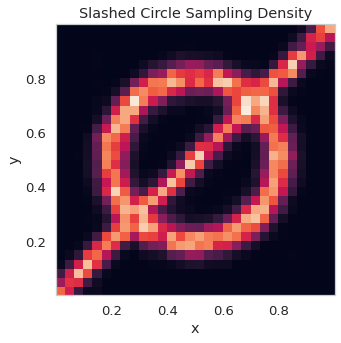

In [335]:
x, _, _ = integrator.sample_refine()
x = x.cpu().numpy()
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)
ax.hist2d(x[:100000,0],x[:100000,1], bins=30)
ax.set(xlabel="x", ylabel="y", title="Slashed Circle Sampling Density")
plt.show()

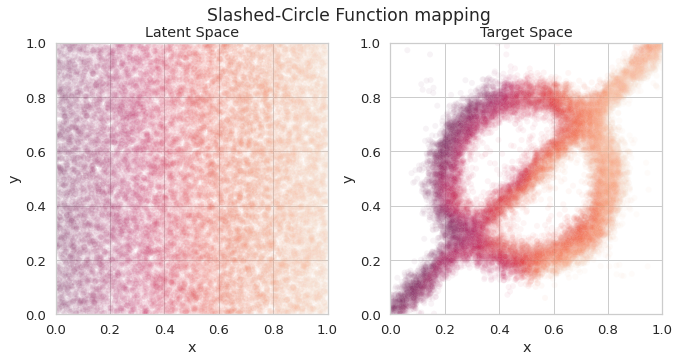

In [336]:
x, _, _ = integrator.sample_survey(n_points=20000)
x = x.cpu()
fig, axs = plt.subplots(1,2)
sns.scatterplot(x=x[:,0], y=x[:,1], hue=x[:,0], legend=False, palette="rocket", hue_norm=(-.5,1.2),alpha=0.05, ax=axs[0])

x = x.to("cuda")
x = torch.cat((x, torch.ones(len(x), device="cuda").unsqueeze(-1)), dim=-1)
y = integrator.model_trainer.flow(x)[:,:2].detach().cpu()
x = x.cpu()

sns.scatterplot(x=y[:,0], y=y[:,1], hue=x[:,0],legend=False, palette="rocket", hue_norm=(-.5,1.2),alpha=0.05, ax=axs[1])
axs[0].set(aspect=1, xlabel="x", ylabel="y", title="Latent Space", xlim=[0,1], ylim=[0,1])
axs[1].set(aspect=1, xlabel="x", ylabel="y", title="Target Space", xlim=[0,1], ylim=[0,1])
fig.set(size_inches=(11,5))
fig.suptitle("Slashed-Circle Function mapping")
plt.show()

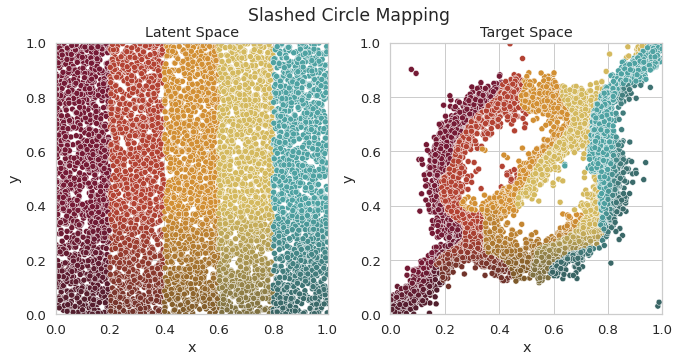

In [337]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,5)
colors = ["#751a35", "#b34233", "#d28f33", "#d4b95e", "#4ea2a2"]
for i in range(5):
    low = i*0.2
    high = low+0.2
    
    x, _, _ = integrator.sample_survey(n_points=7000)
    x = x.cpu()
    x=x[((low<x[:, 0]) &  (x[:,0] < high))]

    sns.scatterplot(x=x[:,0], y=x[:,1], hue=x[:,1], legend=False, palette=sns.dark_palette(colors[i], as_cmap=True), hue_norm=(-.4,.4), ax=axs[0])



    x = x.to("cuda")
    x = torch.cat((x, torch.ones(len(x), device="cuda").unsqueeze(-1)), dim=-1)
    y = integrator.model_trainer.flow(x)[:,:2].detach().cpu()
    x = x.cpu()

    sns.scatterplot(x=y[:,0], y=y[:,1], hue=x[:,1], legend=False, palette=sns.dark_palette(colors[i], as_cmap=True), hue_norm=(-.4,.4),ax=axs[1])

axs[0].set(aspect=1, xlabel="x", ylabel="y", title="Latent Space", xlim=[0,1], ylim=[0,1])
axs[1].set(aspect=1, xlabel="x", ylabel="y", title="Target Space", xlim=[0,1], ylim=[0,1])
fig.set(size_inches=(11,5))
fig.suptitle("Slashed Circle Mapping")
plt.show()

# SineWave integrand

In [338]:
d = 2
s = 0.3
norm = 1

In [339]:
def sw_pretty_plot(config):
    
    benchmarker = VegasRandomHPBenchmarker(n=1)
    config = benchmarker.set_benchmark_grid_config(config=config, cuda=0)
    return benchmarker.run(integrand=SineIntegrand, **config)
    


In [340]:
base_config = Configuration({
    "dimensions": d,
    "base_integrand_params": {
        "f":6,
        "offset": .1
    },
    "base_integrator_config": {
        "checkpoint_on_cuda": False,
        "n_bins": 30,
        "n_epochs": 20,
        "lr": 1.e-3
    },
    "debug":False,
    "experiment_name": "camel_pretty_plot",
    "keep_history": True
}, check=False)



Logging into ./camel_pretty_plot:77d568b.log
0    10.330357
Name: variance_ratio, dtype: float64


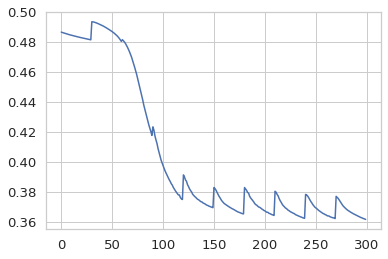

In [341]:
config = deepcopy(base_config)
config["n_epochs"] = 30
config["n_bins"] = 100
config["repetitions"] = 2
config["lr"] = 1e-4
result, integrator = sw_pretty_plot(config)
print(result["variance_ratio"])

fig, ax = plt.subplots()
ax.plot(get_loss_history(result))

plt.show()

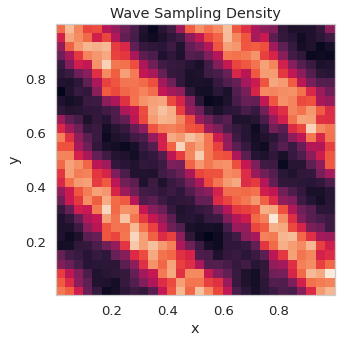

In [342]:
x, _, _ = integrator.sample_refine()
x = x.cpu().numpy()
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)
ax.hist2d(x[:100000,0],x[:100000,1], bins=30)
ax.set(xlabel="x", ylabel="y", title="Wave Sampling Density")
plt.show()

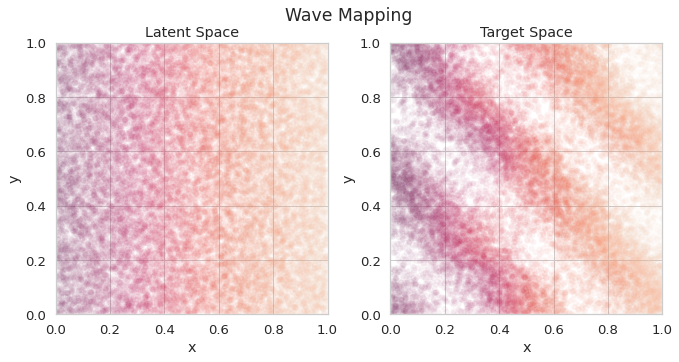

In [343]:
x, _, _ = integrator.sample_survey(n_points=20000)
x = x.cpu()
fig, axs = plt.subplots(1,2)
sns.scatterplot(x=x[:,0], y=x[:,1], hue=x[:,0], legend=False, palette="rocket", hue_norm=(-.5,1.2),alpha=0.05, ax=axs[0])

x = x.to("cuda")
x = torch.cat((x, torch.ones(len(x), device="cuda").unsqueeze(-1)), dim=-1)
y = integrator.model_trainer.flow(x)[:,:2].detach().cpu()
x = x.cpu()

sns.scatterplot(x=y[:,0], y=y[:,1], hue=x[:,0],legend=False, palette="rocket", hue_norm=(-.5,1.2),alpha=0.05, ax=axs[1])
axs[0].set(aspect=1, xlabel="x", ylabel="y", title="Latent Space", xlim=[0,1], ylim=[0,1])
axs[1].set(aspect=1, xlabel="x", ylabel="y", title="Target Space", xlim=[0,1], ylim=[0,1])
fig.set(size_inches=(11,5))
fig.suptitle("Wave Mapping")
plt.show()

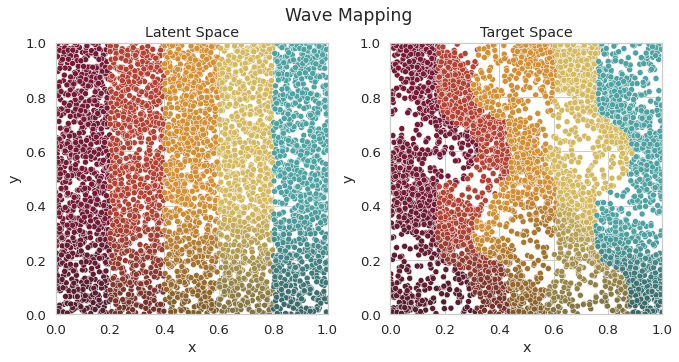

In [344]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,5)
colors = ["#751a35", "#b34233", "#d28f33", "#d4b95e", "#4ea2a2"]
for i in range(5):
    low = i*0.2
    high = low+0.2
    
    x, _, _ = integrator.sample_survey(n_points=5000)
    x = x.cpu()
    x=x[((low<x[:, 0]) &  (x[:,0] < high))]

    sns.scatterplot(x=x[:,0], y=x[:,1], hue=x[:,1], legend=False, palette=sns.dark_palette(colors[i], as_cmap=True), hue_norm=(-.4,.4), ax=axs[0])



    x = x.to("cuda")
    x = torch.cat((x, torch.ones(len(x), device="cuda").unsqueeze(-1)), dim=-1)
    y = integrator.model_trainer.flow(x)[:,:2].detach().cpu()
    x = x.cpu()

    sns.scatterplot(x=y[:,0], y=y[:,1], hue=x[:,1], legend=False, palette=sns.dark_palette(colors[i], as_cmap=True), hue_norm=(-.4,.4),ax=axs[1])

axs[0].set(aspect=1, xlabel="x", ylabel="y", title="Latent Space", xlim=[0,1], ylim=[0,1])
axs[1].set(aspect=1, xlabel="x", ylabel="y", title="Target Space", xlim=[0,1], ylim=[0,1])
fig.set(size_inches=(11,5))
fig.suptitle("Wave Mapping")
plt.show()